# Agile Model Development

In this notebook, we provide a demo on how to perform agile model development.

As what practitioners always say, model building and finetuning actually takes roughly 10-30% of the total model development time.

Remember the big picture that the goal for model development is not to build the best model ever but to deliver an accurate enough, effective, and timely model so that the business stakeholders can make data-driven decisions/actions.

With this, we want to build models in an agile way. This means:
1. We fail fast and iterate often.
2. Per iteration, we think of MVPs (Minimum Viable Products). In this example, this means the actionable list of subscribers who are likely to churn next month.

Note that with the MVP mindset, there are no mention of specific models or data to use.

We don't chase state of the art solution that would take weeks or months to develop.

We focus on what we can do here and now to iteratively develop better MVPs.

Let me show you what I mean.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [2]:
src_path = "drive/MyDrive/dlsu_workshop"

## Setup Simulated Source Databases
We will use our source csv files to simulate the source tables that we need to access in this workshop.

In [3]:
# Create a connection to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# 'topup_transactions' table
tbl_topups = pd.read_csv(f"{src_path}/fake_data/topup_transactions.csv")
tbl_topups.to_sql('topup_transactions', conn, index=False, if_exists='replace')

# 'customer_profile' table
tbl_profiles = pd.read_csv(f"{src_path}/fake_data/customer_profile.csv")
tbl_profiles.to_sql('customer_profile', conn, index=False, if_exists='replace')

# 'usage_summary' table
tbl_usage = pd.read_csv(f"{src_path}/fake_data/usage_summary.csv")
tbl_usage.to_sql('usage_summary', conn, index=False, if_exists='replace')

# 'promo_registration' table
tbl_promos = pd.read_csv(f"{src_path}/fake_data/promo_registration.csv")
tbl_promos.to_sql('promo_registration', conn, index=False, if_exists='replace')

46764

## Monthly Churn Table

In the previous notebook, we created a SQL script for the `user_activity_monthly` table which aggregates monthly data from the different source tables. We also flagged those who churned on that month and created a will_churn flag which we will use in our predictions.

Next, in our EDA, we identified variables that might be good predictors for churn:

1. `tenure_months` or `tenure_class`
2. `segment`
3. `total_data_mb`
4. `age`
5. `topup_count`
6. `promo_count`

We noted however that `age` is potentially correlated with tenure and segment variables. Also, `toup_count` and `promo_count` are potentially correlated to `usage`.

In [4]:
# create monthly table with churn labels
q_monthly = """
CREATE TABLE user_activity_monthly AS
WITH months AS (
  SELECT DISTINCT month FROM (
    SELECT month FROM usage_summary
    UNION
    SELECT month FROM topup_transactions
    UNION
    SELECT month FROM promo_registration
  )
),

users AS (
  SELECT DISTINCT user_id, registration_date FROM customer_profile
),

active_months AS (
  SELECT u.user_id, m.month
  FROM users u
  CROSS JOIN months m
  WHERE m.month >= strftime('%Y_%m', u.registration_date)
),

usage_agg AS (
  SELECT
    user_id,
    month,
    SUM(data_mb) AS total_data_mb,
    SUM(voice_minutes) AS total_voice_minutes,
    SUM(sms_count) AS total_sms_count,
    CASE WHEN SUM(data_mb) > 0 OR SUM(voice_minutes) > 0 OR SUM(sms_count) > 0 THEN 1 ELSE 0 END AS has_usage
  FROM usage_summary
  GROUP BY user_id, month
),

topup_agg AS (
  SELECT
    user_id,
    month,
    COUNT(*) AS topup_count,
    SUM(topup_amount) AS total_topup_amount,
    1 AS has_topup
  FROM topup_transactions
  GROUP BY user_id, month
),

promo_agg AS (
  SELECT
    user_id,
    month,
    COUNT(*) AS promo_count,
    1 AS has_promo
  FROM promo_registration
  GROUP BY user_id, month
),

joined AS (
  SELECT
    a.user_id,
    a.month,
    COALESCE(u.has_usage, 0) AS has_usage,
    COALESCE(u.total_data_mb, 0) AS total_data_mb,
    COALESCE(u.total_voice_minutes, 0) AS total_voice_minutes,
    COALESCE(u.total_sms_count, 0) AS total_sms_count,

    COALESCE(t.has_topup, 0) AS has_topup,
    COALESCE(t.topup_count, 0) AS topup_count,
    COALESCE(t.total_topup_amount, 0) AS total_topup_amount,

    COALESCE(p.has_promo, 0) AS has_promo,
    COALESCE(p.promo_count, 0) AS promo_count
  FROM active_months a
  LEFT JOIN usage_agg u ON a.user_id = u.user_id AND a.month = u.month
  LEFT JOIN topup_agg t ON a.user_id = t.user_id AND a.month = t.month
  LEFT JOIN promo_agg p ON a.user_id = p.user_id AND a.month = p.month
),

activity_flagged AS (
  SELECT *,
    CASE
      WHEN has_usage = 0 AND has_topup = 0 AND has_promo = 0 THEN 1
      ELSE 0
    END AS churned
  FROM joined
),

first_churn AS (
  SELECT user_id, MIN(month) AS first_churn_month
  FROM activity_flagged
  WHERE churned = 1
  GROUP BY user_id
)

SELECT
  a.user_id,
  a.month,
  a.has_usage,
  a.total_data_mb,
  a.total_voice_minutes,
  a.total_sms_count,
  a.has_topup,
  a.topup_count,
  a.total_topup_amount,
  a.has_promo,
  a.promo_count,
  a.churned
FROM activity_flagged a
LEFT JOIN first_churn f
  ON a.user_id = f.user_id AND a.month = f.first_churn_month
WHERE a.churned = 0 OR f.first_churn_month IS NOT NULL
ORDER BY a.user_id, a.month;
"""

# drop table if it already exists
q_drop_table = """
DROP TABLE IF EXISTS user_activity_monthly;
"""

conn.execute(q_drop_table)
conn.execute(q_monthly)

In [5]:
q_monthly = """
SELECT *
FROM user_activity_monthly
"""

df_monthly = pd.read_sql(q_monthly, conn)
df_monthly.head()

,user_id,month,has_usage,total_data_mb,total_voice_minutes,total_sms_count,has_topup,topup_count,total_topup_amount,has_promo,promo_count,churned
0,U0000000,2024_07,1,174.84,0,0,1,1,100,0,0,0
1,U0000000,2024_08,1,69.94,0,4,0,0,0,0,0,0
2,U0000000,2024_09,1,69.94,0,0,0,0,0,0,0,0
3,U0000000,2024_10,1,48.96,0,0,1,1,50,0,0,0
4,U0000000,2024_11,1,34.27,0,0,1,1,20,0,0,0


In [6]:
def add_churn_next_month_label(df, user_col='user_id',
                               churn_col='churned',
                               label_col='will_churn',
                               dropna=True):
    # Ensure month is sortable
    df_ = df.copy()

    # Sort the data
    df_ = df_.sort_values([user_col, 'month'])

    # Generate shifted churn label
    df_[label_col] = df_.groupby(user_col)[churn_col].shift(-1)

    # Handle missing future-month labels
    if dropna:
        df_ = df_[df_[label_col].notna()]
    else:
        df_[label_col] = df_[label_col].fillna(0).astype(int)

    return df_


df_labeled_monthly = add_churn_next_month_label(df_monthly)
# drop churned column
df_labeled_monthly = df_labeled_monthly.drop(columns=['churned'])
df_labeled_monthly.head()

,user_id,month,has_usage,total_data_mb,total_voice_minutes,total_sms_count,has_topup,topup_count,total_topup_amount,has_promo,promo_count,will_churn
0,U0000000,2024_07,1,174.84,0,0,1,1,100,0,0,0.0
1,U0000000,2024_08,1,69.94,0,4,0,0,0,0,0,0.0
2,U0000000,2024_09,1,69.94,0,0,0,0,0,0,0,0.0
3,U0000000,2024_10,1,48.96,0,0,1,1,50,0,0,0.0
4,U0000000,2024_11,1,34.27,0,0,1,1,20,0,0,0.0


In [7]:
# Test Connection to Topup table
q_profiles = """
SELECT *
FROM customer_profile
"""

df_profiles = pd.read_sql_query(q_profiles, conn)
df_profiles.head()

,user_id,month,segment,tenure_months,tenure_class,registration_date,device_type,gender,age
0,U0000000,2024_07,01_new_user,4,01_new,2024-03-01,feature_phone,female,38
1,U0000000,2024_08,01_new_user,5,01_new,2024-03-01,feature_phone,female,38
2,U0000000,2024_09,01_new_user,6,01_new,2024-03-01,feature_phone,female,38
3,U0000000,2024_10,01_new_user,7,02_post_onboarding,2024-03-01,feature_phone,female,38
4,U0000000,2024_11,01_new_user,8,02_post_onboarding,2024-03-01,feature_phone,female,38


In [8]:
# add profiles
df_labeled_monthly = df_profiles.merge(df_labeled_monthly, on=['user_id', 'month'], how='inner')
df_labeled_monthly.head()

,user_id,month,segment,tenure_months,tenure_class,registration_date,device_type,gender,age,has_usage,total_data_mb,total_voice_minutes,total_sms_count,has_topup,topup_count,total_topup_amount,has_promo,promo_count,will_churn
0,U0000000,2024_07,01_new_user,4,01_new,2024-03-01,feature_phone,female,38,1,174.84,0,0,1,1,100,0,0,0.0
1,U0000000,2024_08,01_new_user,5,01_new,2024-03-01,feature_phone,female,38,1,69.94,0,4,0,0,0,0,0,0.0
2,U0000000,2024_09,01_new_user,6,01_new,2024-03-01,feature_phone,female,38,1,69.94,0,0,0,0,0,0,0,0.0
3,U0000000,2024_10,01_new_user,7,02_post_onboarding,2024-03-01,feature_phone,female,38,1,48.96,0,0,1,1,50,0,0,0.0
4,U0000000,2024_11,01_new_user,8,02_post_onboarding,2024-03-01,feature_phone,female,38,1,34.27,0,0,1,1,20,0,0,0.0


The table above is referred to as an Analytics Base Table (ABT). It contains variables relevant to model building—such as potential predictor variables, the target variable, and identifying fields like ID and date.

## Benchmark Models
While it’s possible to use this table directly (with minimal thought) to develop our first model, doing so would reflect poor modeling practice. When creating a **benchmark model**, our goal is to keep it as simple and explainable as possible. This ensures that when we present the model to stakeholders, it is easier for them to understand—and therefore easier for us to gain their **buy-in** for its use.

For this use case, remember that we are trying to build a model that predicts who are likely to churn in the following month.

In [9]:
df_labeled_monthly.month.min(), df_labeled_monthly.month.max()

('2024_07', '2025_05')

In [10]:
df_train = df_labeled_monthly[df_labeled_monthly.month < '2025_01']
df_test = df_labeled_monthly[df_labeled_monthly.month >= '2025_01']

### Train-Test Split
Before we begin building a model, we need to split our data into a training set and a test set.

We use the training set to build the model, and we use the test set to evaluate model performance.

Now, our data is a bit special since we need to be mindful of the time component. Thus, our data on the test set should not be from the period covered in the training set.

Now, we have data from July 2024 to May 2025 for this analysis.

I'll use data from July 2024 to December 2024 for training, and I will test the performance monthly from Jan-May 2025.

### Attempt 1: Kaplan Meiers Curve
Fortunately, statisticians have created simple solutions for churn model that works with minimal data, and minimal predictor variables. As a benchmark, we will use the [Kaplan-Meier curve](https://datatab.net/tutorial/kaplan-meier-curve).

![Kaplan-Meier Curve](https://cdn.prod.website-files.com/621e95f9ac30687a56e4297e/64adcb0349cb9ba82b4fcd3f_V2_1687444748302_6f71535e-580e-4bb8-887f-dedab53a5d8e_HIGH_RES.png)

Now for the KM model, I will install the lifelines package in python.

In [11]:
!pip install -q lifelines

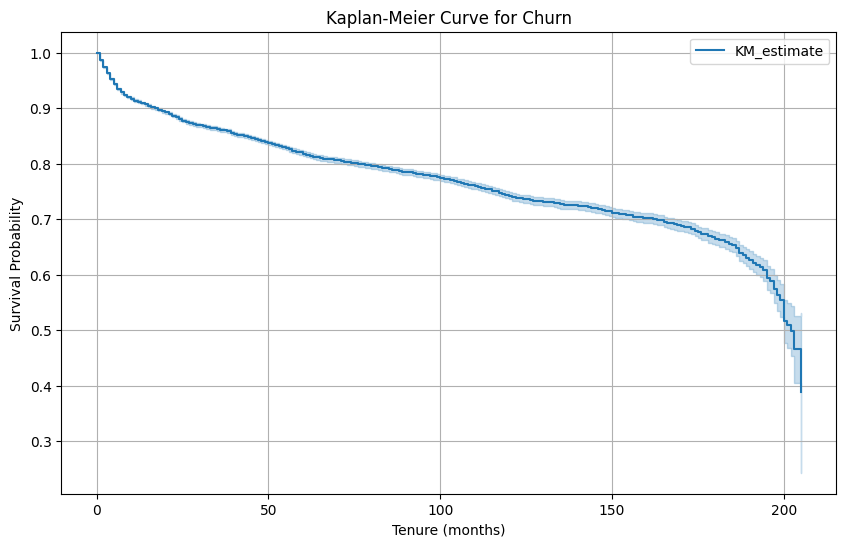

In [12]:
from lifelines import KaplanMeierFitter
from IPython.display import display

# Create an instance of the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Duration: tenure_months, Event: will_churn (1 = churned, 0 = still active)
duration = df_train['tenure_months']
event_observed = df_train['will_churn'] == 1  # Ensure this is boolean

# Fit the Kaplan-Meier estimator
kmf.fit(durations=duration, event_observed=event_observed)

# Plot the survival function
plt.figure(figsize=(10,6))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Curve for Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

In [13]:
df_churn_lookup_table = kmf.predict(list(range(1, df_train.tenure_months.max()))).to_frame()

# rename index to tenure_months
df_churn_lookup_table.index.name = 'tenure_months'

df_churn_lookup_table['proba_churn'] = 1 - df_churn_lookup_table.KM_estimate
df_churn_lookup_table.head()

,KM_estimate,proba_churn
tenure_months,,
1,0.986541,0.013459
2,0.973629,0.026371
3,0.962585,0.037415
4,0.952638,0.047362
5,0.943030,0.056970


In [14]:
def map_tenure_to_churn(tenure_months, df_churn_lookup_table):
    # if tenure_months in index map directly
    if tenure_months in df_churn_lookup_table.index:
        return df_churn_lookup_table.loc[tenure_months, 'proba_churn']

    # otherwise get max churn proba
    return df_churn_lookup_table.proba_churn.max()

df_train.loc[:, 'proba_churn_km'] = df_train.tenure_months.map(lambda x: map_tenure_to_churn(x, df_churn_lookup_table))
df_train.loc[:, 'will_churn_km'] = (df_train.proba_churn_km > 0.5).astype(int)
df_train.loc[:, ['proba_churn_km', 'will_churn_km', 'will_churn']].head()

/tmp/ipython-input-14-1135717462.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'proba_churn_km'] = df_train.tenure_months.map(lambda x: map_tenure_to_churn(x, df_churn_lookup_table))
/tmp/ipython-input-14-1135717462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'will_churn_km'] = (df_train.proba_churn_km > 0.5).astype(int)


,proba_churn_km,will_churn_km,will_churn
0,0.047362,0,0.0
1,0.056970,0,0.0
2,0.065354,0,0.0
3,0.071531,0,0.0
4,0.075981,0,0.0


In [15]:
# show accuracy, precision, & recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def compute_metrics(y_true, y_proba):
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    # display cross tab
    display(pd.crosstab(y_true, y_pred))

    print()
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"AUC: {auc:.2f}")

    return acc, prec, rec, auc

acc_km, prec_km, rec_km, rec_auc = compute_metrics(df_train['will_churn'], df_train['proba_churn_km'])

proba_churn_km,0,1
will_churn,,
0.0,53383,45
1.0,7642,4



Accuracy: 0.87
Precision: 0.08
Recall: 0.00
AUC: 0.45


Looking at the results, it seems that KM predicted everything to be zero even on the training set.

AUC is also below 0.5 which means that our model is performing worse than random.

This gives us a view that models which may have sound theoretical framework might fail when faced with real data. Now, we won't spend more time working on this. We **fail fast** and pivot to another approach.

### Attempt 2: LogReg - Tenure

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Prep: Features and target
X_train = df_train.loc[:, ['tenure_months']]  # You can later add more columns here
y_train = df_train['will_churn'].astype(int)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.55


(0.8748076104397944, 0.0, 0.0, np.float64(0.5501584270218296))

Even with logistic regression tenure_months just doesn't work. However, we note that now, AUC is > .5. This means that our predicted probabilities are better than random albeit not quiet good yet.

Let's try tenure_class next.

### Attempt 3: LogReg - Tenure Class

For Tenure Class, it is a categorical variable. We need to perform some preprocessing to make it work as an input variable in our model.

In [17]:
# feature engineering - use one-hot encoding
X_train_tenure_class = pd.get_dummies(df_train.tenure_class).astype(int)
X_train_tenure_class.head()

,01_new,02_post_onboarding,03_established,04_6_to_10_years,05_over_10_years
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [18]:
# build model
model = LogisticRegression()
model.fit(X_train_tenure_class, y_train)

y_pred = model.predict(X_train_tenure_class)
y_proba = model.predict_proba(X_train_tenure_class)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.56


(0.8748076104397944, 0.0, 0.0, np.float64(0.5580372063788972))

Same results again. We take note and move forward.

### Attempt 4: LogReg - Segment

In [19]:
# feature engineering - one hut encoding for segment variable
X_train_segment = pd.get_dummies(df_train.segment).astype(int)

In [20]:
# build model
model = LogisticRegression()
model.fit(X_train_segment, y_train)

y_pred = model.predict(X_train_segment)
y_proba = model.predict_proba(X_train_segment)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.64


(0.8748076104397944, 0.0, 0.0, np.float64(0.639768772595136))

Okay. With segment, we're seeing an improvement in AUC curve. This is still low but at least it seems like we're on the right track.

### Attempt 5: LogReg - Numeric Variables

We also knew that data_mb is a potential predictor. We'll test it here.

In [21]:
# create X_train with total_data_mb
X_train = df_train.loc[:, ['total_data_mb']]

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.58


(0.8748076104397944, 0.0, 0.0, np.float64(0.5845099257280268))

In [22]:
# create X_train with topup_count
X_train = df_train.loc[:, ['total_topup_amount']]

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.58


(0.8748076104397944, 0.0, 0.0, np.float64(0.5786752322011375))

Topup is slightly better than data usage.

In [23]:
# create X_train with promo_count
X_train = df_train.loc[:, ['promo_count']]

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.51


(0.8748076104397944, 0.0, 0.0, np.float64(0.507288271874185))

Promo count is practically as good as random.

In [24]:
# create X_train with promo_count
X_train = df_train.loc[:, ['age']]

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,53428
1,7646



Accuracy: 0.87
Precision: 0.00
Recall: 0.00
AUC: 0.59


(0.8748076104397944, 0.0, 0.0, np.float64(0.5867254380014841))

Age on its own have same AUC with `tenure_class`. Which we noted in our EDA are potentially correlated.

## Checkpoint
So far, we're getting bad performance from our models. We are getting some insights though:

1. LogReg is better than KM.
2. Tenure, Tenure class, & Age have the same AUC.
3. Segment gives us the best train AUC.
4. total_data_mb and topup_amount seem to have some signals.

### Next Actions We Can Take
#### LogReg on Combination of Variables
`tenure_months` + `segment` + `total_data_mb` + `topup_amount`.

- Although, we note that topup_amount is potentially correlated with `total_data_mb` or `segment`

#### Feature Engineering  
a. instead of one-hut encoding the segment, we can use weight-of-evidence (WOE) to avoid increasing the variable counts    
b. for tenure and total_data_mb, we can apply log transforms  
c. we can also check for change in total_data_mb usage from previous month to now

#### Model Selection  
a. Try Decision Trees for interpretability  
b. Try RandomForest and XGBoost  

#### Calibrate Threshold  
a. Once we get a good performing model (AUC about .7), we then calibrate the threshold to get better performance on accuracy, precision, and recall.  

#### Evaluate of Test Data  
a. So far, we skipped evaluations on the test data because our model is still **underfit**. Once we have sufficient fit on the training data, we will check on the test data.

### Feature Engineering
Use Weight of Evidence, Log Transform, and Change in Data Usage From Previous Month

In [25]:
# data usage from previous month

def add_prev_data_mb(df):
    """
    Adds a column 'prev_data_mb' containing the previous month's total_data_mb per user.

    Parameters:
    df (pd.DataFrame): Must contain 'user_id', 'month', and 'total_data_mb' columns.

    Returns:
    pd.DataFrame: Same as input but with an added 'prev_data_mb' column.
    """
    df = df.copy()
    df = df.sort_values(['user_id', 'month'])
    df['prev_data_mb'] = df.groupby('user_id')['total_data_mb'].shift(1)
    return df

df_labeled_monthly = add_prev_data_mb(df_labeled_monthly)

# drop rows where prev_data_mb is Null
df_labeled_monthly = df_labeled_monthly.dropna(subset=['prev_data_mb'])

df_labeled_monthly.head()

,user_id,month,segment,tenure_months,tenure_class,registration_date,device_type,gender,age,has_usage,total_data_mb,total_voice_minutes,total_sms_count,has_topup,topup_count,total_topup_amount,has_promo,promo_count,will_churn,prev_data_mb
1,U0000000,2024_08,01_new_user,5,01_new,2024-03-01,feature_phone,female,38,1,69.94,0,4,0,0,0,0,0,0.0,174.84
2,U0000000,2024_09,01_new_user,6,01_new,2024-03-01,feature_phone,female,38,1,69.94,0,0,0,0,0,0,0,0.0,69.94
3,U0000000,2024_10,01_new_user,7,02_post_onboarding,2024-03-01,feature_phone,female,38,1,48.96,0,0,1,1,50,0,0,0.0,69.94
4,U0000000,2024_11,01_new_user,8,02_post_onboarding,2024-03-01,feature_phone,female,38,1,34.27,0,0,1,1,20,0,0,0.0,48.96
5,U0000000,2024_12,01_new_user,9,02_post_onboarding,2024-03-01,feature_phone,female,38,1,13.71,1,0,0,0,0,0,0,0.0,34.27


In [26]:
df_labeled_monthly.month.min(), df_labeled_monthly.month.max()

('2024_08', '2025_05')

Okay, now we have the previous total mb.

We can now compute for the change in total data mb usage. We note that since we don't have previous total mb for the first month, we need to drop those rows.

In [27]:
df_labeled_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85944 entries, 1 to 105913
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              85944 non-null  object 
 1   month                85944 non-null  object 
 2   segment              85944 non-null  object 
 3   tenure_months        85944 non-null  int64  
 4   tenure_class         85944 non-null  object 
 5   registration_date    85944 non-null  object 
 6   device_type          85944 non-null  object 
 7   gender               85944 non-null  object 
 8   age                  85944 non-null  int64  
 9   has_usage            85944 non-null  int64  
 10  total_data_mb        85944 non-null  float64
 11  total_voice_minutes  85944 non-null  int64  
 12  total_sms_count      85944 non-null  int64  
 13  has_topup            85944 non-null  int64  
 14  topup_count          85944 non-null  int64  
 15  total_topup_amount   85944 non-null  int

In [28]:
# compute %change in data usage

def compute_data_usage_change(df, curr_mb_col='total_data_mb', prev_mb_col='prev_data_mb'):
    df = df.copy()

    # add small positive value for numerical stability
    df['data_usage_change'] = (df[curr_mb_col] - df[prev_mb_col]) / (df[prev_mb_col] + 1E-6  )

    return df

df_labeled_monthly_new = compute_data_usage_change(df_labeled_monthly)


df_labeled_monthly_new.head()

,user_id,month,segment,tenure_months,tenure_class,registration_date,device_type,gender,age,has_usage,...,total_voice_minutes,total_sms_count,has_topup,topup_count,total_topup_amount,has_promo,promo_count,will_churn,prev_data_mb,data_usage_change
1,U0000000,2024_08,01_new_user,5,01_new,2024-03-01,feature_phone,female,38,1,...,0,4,0,0,0,0,0,0.0,174.84,-0.599977
2,U0000000,2024_09,01_new_user,6,01_new,2024-03-01,feature_phone,female,38,1,...,0,0,0,0,0,0,0,0.0,69.94,0.000000
3,U0000000,2024_10,01_new_user,7,02_post_onboarding,2024-03-01,feature_phone,female,38,1,...,0,0,1,1,50,0,0,0.0,69.94,-0.299971
4,U0000000,2024_11,01_new_user,8,02_post_onboarding,2024-03-01,feature_phone,female,38,1,...,0,0,1,1,20,0,0,0.0,48.96,-0.300041
5,U0000000,2024_12,01_new_user,9,02_post_onboarding,2024-03-01,feature_phone,female,38,1,...,1,0,0,0,0,0,0,0.0,34.27,-0.599942


In [29]:
# split data into train and test sets again
df_train = df_labeled_monthly_new[df_labeled_monthly_new.month < '2025_01']
df_test = df_labeled_monthly_new[df_labeled_monthly_new.month >= '2025_01']


### Attempt 6: LogReg on Usage Change

In [30]:
# create X_train with data_usage_change
X_train = df_train.loc[:, ['data_usage_change']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,39445
1,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.58


(0.8754272271294775, 0.0, 0.0, np.float64(0.5832071131615335))

Okay. The performance is the same as total_data_mb. Let's check for correlation between the two

In [31]:
# compute correlation in df_train for total_data_mb and data_usage_change
df_train[['total_data_mb', 'data_usage_change']].corr()

,total_data_mb,data_usage_change
total_data_mb,1.000000,0.328399
data_usage_change,0.328399,1.000000


Nice. The correlation is pretty low. Hence, we can add this as another feature. Let's quickly try using both usage features now.

### Attempt 7: LogReg on Usage Features

In [32]:
# create X_train with data_usage_change
X_train = df_train.loc[:, ['total_data_mb', 'data_usage_change']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,39445
1,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.61


(0.8754272271294775, 0.0, 0.0, np.float64(0.6094850321324357))

Awesome! Using our engineered feature, we increase the AUC from the usage variable. Let's now perform additional feature engineering on other variables as planned

In [55]:
# log transform on tenure, total_data_mb, and total_topup
df_train.loc[:, 'log_tenure_months'] = np.log(df_train['tenure_months'] + 1E-9)
df_train.loc[:, 'log_total_data_mb'] = np.log(df_train['total_data_mb'] + 1E-9)
df_train.loc[:, 'log_total_amount'] = np.log(df_train['total_topup_amount'] + 1E-9)

df_test.loc[:, 'log_tenure_months'] = np.log(df_test['tenure_months'] + 1E-9)
df_test.loc[:, 'log_total_data_mb'] = np.log(df_test['total_data_mb'] + 1E-9)
df_test.loc[:, 'log_total_amount'] = np.log(df_test['total_topup_amount'] + 1E-9)

/tmp/ipython-input-55-1322510845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'log_tenure_months'] = np.log(df_train['tenure_months'] + 1E-9)
/tmp/ipython-input-55-1322510845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'log_tenure_months'] = np.log(df_test['tenure_months'] + 1E-9)


### Attempt 8: LogReg on Engineered Numeric Features

In [56]:
# create X_train with data_usage_change
X_train = df_train.loc[:, ['log_tenure_months', 'log_total_data_mb', 'data_usage_change', 'log_total_amount']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

col_0,0,1
will_churn,,
0,39418,27
1,5607,6



Accuracy: 0.87
Precision: 0.18
Recall: 0.00
AUC: 0.61


In [57]:
# create X_train with data_usage_change
X_train = df_train.loc[:, ['log_tenure_months', 'log_total_data_mb', 'data_usage_change']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

col_0,0,1
will_churn,,
0,39418,27
1,5607,6



Accuracy: 0.87
Precision: 0.18
Recall: 0.00
AUC: 0.61


In [58]:
# create X_train with data_usage_change
X_train = df_train.loc[:, ['log_total_data_mb', 'data_usage_change']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

col_0,0,1
will_churn,,
0,39418,27
1,5607,6



Accuracy: 0.87
Precision: 0.18
Recall: 0.00
AUC: 0.61


From the models above, it seems like
1. the log transform does not add any significant signal and,
2. adding the total amount and tenure to the usage is just noise

In [42]:
!pip install -q feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 13.1 MB/s eta 0:00:00


### Attempt 9: LogReg on Engineered Segment Feature

In [43]:
# import woe encoder
from feature_engine.encoding import WoEEncoder

In [53]:
# Initialize and fit WoEEncoder
woe_encoder = WoEEncoder(variables=['segment'])
woe_encoder.fit(df_train[['segment']], y_train)

# Transform the data
df_train.loc[:, 'segment_woe'] = woe_encoder.transform(df_train[['segment']]).values
df_test.loc[:, 'segment_woe'] = woe_encoder.transform(df_test[['segment']]).values

In [54]:
# check performance of segment_woe
X_train = df_train.loc[:, ['segment_woe']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,39445
1,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.64


Okay. So we are able to keep the same AUC for segment but instead of having multiple variables using the one-hot encoding, we now have just one. Nice!

### Attempt 10 - LogReg on Segment WoE and Usage

In [59]:
# check performance of segment_woe
X_train = df_train.loc[:, ['segment_woe', 'log_total_data_mb',
                           'data_usage_change']]
y_train = df_train['will_churn'].astype(int)

# build model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_proba = model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0,39445
1,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.65


We see some slight improvement. We're making progress!

### Attempt 11: Use Decision Trees

In [60]:
# Use Decision Trees
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

y_pred = model_dt.predict(X_train)
y_proba = model_dt.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

col_0,0,1
will_churn,,
0,39439,6
1,822,4791



Accuracy: 0.98
Precision: 1.00
Recall: 0.85
AUC: 1.00


Wow! Immediately, we see massive improvements using the decision tree.

However, we run into another issue now! Our performance seems to good to be true!

This is a sign of **overfitting** which could mean:  
1. the model "memorized" the training set but may not be replicable in the test set. To check this, we evaluate the performance of the model on our test set.

2. Data leakage. Data leakage is when you are using some information about the target variable within the feature variables. Note that our WoE transform uses the target as part of the preprocessing and is suspect for data leakage. In our setup, since the WoE transformer is fit using the training set only, it should not be an issue.

With both things in mind, let's quickly evaluate the test set.

In [61]:
y_proba_test = model_dt.predict_proba(df_test.loc[:, ['segment_woe', 'log_total_data_mb', 'data_usage_change']])[:, 1]

compute_metrics(df_test['will_churn'], y_proba_test);

col_0,0,1
will_churn,,
0.0,32073,4209
1.0,3855,749



Accuracy: 0.80
Precision: 0.15
Recall: 0.16
AUC: 0.52


As we suspected, we indeed have a case of overfitting. Hence, we should perform **model tuning**.

### Attempt 12: Model Tuning

In [97]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# --- 1. Prepare training data ---
# Convert 'YYYY_MM' to datetime
df_train.loc[:, 'month'] = pd.to_datetime(df_train['month'], format='%Y_%m')
df_train = df_train.sort_values('month')

X_train = df_train[['segment_woe', 'log_total_data_mb', 'data_usage_change']]
y_train = df_train['will_churn']

In [98]:
X_train.head()

,segment_woe,log_total_data_mb,data_usage_change
1,0.835358,4.247638,-0.599977
29350,0.297824,6.184973,-0.499995
29360,0.297824,6.026397,-0.500006
29367,0.297824,6.416814,0.299994
29375,0.297824,5.415033,-0.500000


In [100]:
# --- 2. Set up time-aware CV and hyperparameter grid ---
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

In [101]:
# --- 3. Fit the model using TimeSeriesSplit ---
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Best Parameters:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [102]:
best_model_dt = grid_search.best_estimator_

y_proba_train = best_model_dt.predict_proba(X_train)[:, 1]
compute_metrics(y_train, y_proba_train)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0.0,39445
1.0,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.65


(0.8754272271294775, 0.0, 0.0, np.float64(0.6494673952055734))

In [104]:
y_proba_test = best_model_dt.predict_proba(df_test.loc[:, ['segment_woe', 'log_total_data_mb', 'data_usage_change']])[:, 1]

compute_metrics(df_test['will_churn'], y_proba_test);

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0.0,36282
1.0,4604



Accuracy: 0.89
Precision: 0.00
Recall: 0.00
AUC: 0.65


Okay, we now have a tuned model. Notice that the train and test AUC results are fairly consistent now which shows that we have now prevented overfitting. However, this performance is still low.

Let's try XGBoost next to see if we can get some improvements. We will still perform tuning and cross validation to avoid overfitting.

### Attempt 13: Using XGBoost

In [81]:
from xgboost import XGBClassifier, plot_importance

In [82]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# --- 3. Fit with time-respecting CV ---
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [83]:
best_model = grid_search.best_estimator_

y_proba_train = best_model.predict_proba(X_train)[:, 1]
compute_metrics(y_train, y_proba_train)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0.0,39445
1.0,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.66


(0.8754272271294775, 0.0, 0.0, np.float64(0.659684979256433))

In [84]:
y_proba_test = best_model.predict_proba(df_test.loc[:, ['segment_woe', 'log_total_data_mb', 'data_usage_change']])[:, 1]
compute_metrics(df_test['will_churn'], y_proba_test);

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0.0,36282
1.0,4604



Accuracy: 0.89
Precision: 0.00
Recall: 0.00
AUC: 0.65


Okay. Note that we did not get better results from using XGBoost. This means that even after using a more advanced model, the performance remains the same.

At this point, we can either try and push to use more advanced models like Deep Learning models and LLM Classifers or begin building our business case given our current findings.

Again, given our agile mindset, we prioritize talking to clients about what we already have before investing more time on more advanced models that may not be fruitful.

Also, remember that we can also perform CV on the logistic regression model since the performance with DT is comparable. Let's do that before finalizing the model building phase.

### Attempt 14: Tuning LogReg

In [85]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# --- 3. Fit model with time-aware cross-validation ---
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Parameters:
{'C': 0.1, 'penalty': 'l1'}


In [86]:
best_model = grid_search.best_estimator_

y_proba = best_model.predict_proba(X_train)[:, 1]

compute_metrics(y_train, y_proba);

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0.0,39445
1.0,5613



Accuracy: 0.88
Precision: 0.00
Recall: 0.00
AUC: 0.65


In [87]:
y_proba_test = best_model.predict_proba(df_test.loc[:, ['segment_woe', 'log_total_data_mb', 'data_usage_change']])[:, 1]
compute_metrics(df_test['will_churn'], y_proba_test);

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


col_0,0
will_churn,
0.0,36282
1.0,4604



Accuracy: 0.89
Precision: 0.00
Recall: 0.00
AUC: 0.66


We have a very similar performance with the Decision Tree. With this, it is wise to stop building new models and start preparing the report to our stakeholders.

## What Now?
Given the similar performance between Logistic Regression, Decision Tree, and XGBoost, we pick the most interpretable model.

The leaves us with either LR or DT. From experience, given that we only have very few variables (only 3), DT is more likely to be more interpretable since we can convert them into simple decision rules.

In [105]:
from sklearn.tree import _tree

def extract_decision_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, depth, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Left branch
            recurse(tree_.children_left[node], depth + 1,
                    path + [f"{name} <= {threshold:.2f}"])

            # Right branch
            recurse(tree_.children_right[node], depth + 1,
                    path + [f"{name} > {threshold:.2f}"])
        else:
            samples = tree_.n_node_samples[node]
            value = tree_.value[node][0]
            proba = value / value.sum()
            predicted_class = proba.argmax()

            rules.append({
                "rule": " AND ".join(path),
                "n_samples": samples,
                "predicted_class": predicted_class,
                "proba_no_churn": proba[0],
                "proba_churn": proba[1],
            })

    recurse(0, 1, [])
    return pd.DataFrame(rules)


rule_table = extract_decision_rules(best_model_dt, feature_names=X_train.columns)

# drop predicted_class and proba_no_churn
rule_table = rule_table.drop(columns=['predicted_class', 'proba_no_churn']).sort_values('proba_churn')

# display table and round off proba_churn
rule_table.style.format({'proba_churn': "{:.2%}"})

,rule,n_samples,proba_churn
0,segment_woe <= 0.10 AND segment_woe <= -0.30 AND segment_woe <= -0.81,5722,4.46%
1,segment_woe <= 0.10 AND segment_woe <= -0.30 AND segment_woe > -0.81,10276,7.93%
3,segment_woe <= 0.10 AND segment_woe > -0.30 AND log_total_data_mb > 6.21,3320,9.82%
2,segment_woe <= 0.10 AND segment_woe > -0.30 AND log_total_data_mb <= 6.21,8401,11.97%
7,segment_woe > 0.10 AND log_total_data_mb > 4.54 AND log_total_data_mb > 6.09,6698,13.80%
6,segment_woe > 0.10 AND log_total_data_mb > 4.54 AND log_total_data_mb <= 6.09,7466,19.18%
5,segment_woe > 0.10 AND log_total_data_mb <= 4.54 AND data_usage_change > -0.60,2571,25.79%
4,segment_woe > 0.10 AND log_total_data_mb <= 4.54 AND data_usage_change <= -0.60,604,31.79%


From above there are 8 rules governing the entire decision making process. We will simplify these rules further.

In [106]:
rule_table['rule_split'] = rule_table.rule.str.split(' AND ')
rule_table['segment_rules'] = rule_table.rule_split.apply(lambda rules: [r for r in rules if 'segment' in r])
rule_table['data_usage_rules'] = rule_table.rule_split.apply(lambda rules: [r for r in rules if 'total_data' in r])
rule_table['usage_change_rules'] = rule_table.rule_split.apply(lambda rules: [r for r in rules if 'data_usage_change' in r])

# drop rule split
rule_table_new = rule_table.drop(columns=['rule_split', 'rule'])

rule_table_new.style.format({'proba_churn': "{:.2%}"})

,n_samples,proba_churn,segment_rules,data_usage_rules,usage_change_rules
0,5722,4.46%,"['segment_woe <= 0.10', 'segment_woe <= -0.30', 'segment_woe <= -0.81']",[],[]
1,10276,7.93%,"['segment_woe <= 0.10', 'segment_woe <= -0.30', 'segment_woe > -0.81']",[],[]
3,3320,9.82%,"['segment_woe <= 0.10', 'segment_woe > -0.30']",['log_total_data_mb > 6.21'],[]
2,8401,11.97%,"['segment_woe <= 0.10', 'segment_woe > -0.30']",['log_total_data_mb <= 6.21'],[]
7,6698,13.80%,['segment_woe > 0.10'],"['log_total_data_mb > 4.54', 'log_total_data_mb > 6.09']",[]
6,7466,19.18%,['segment_woe > 0.10'],"['log_total_data_mb > 4.54', 'log_total_data_mb <= 6.09']",[]
5,2571,25.79%,['segment_woe > 0.10'],['log_total_data_mb <= 4.54'],['data_usage_change > -0.60']
4,604,31.79%,['segment_woe > 0.10'],['log_total_data_mb <= 4.54'],['data_usage_change <= -0.60']


In [77]:
df_train[['segment', 'segment_woe']].drop_duplicates().sort_values('segment_woe')

,segment,segment_woe
40910,05_high_roller,-1.115400
38720,04_mature,-0.501923
46430,03_value_seeker,-0.104244
64645,02_youth,0.297824
1,01_new_user,0.835358


In [121]:
segment_rules = ['05_high_roller', '04_mature', '03_value_seeker', '03_value_seeker',
                 '02_new_user_or_01_youth', '02_new_user_or_01_youth', '02_new_user_or_01_youth', '02_new_user_or_01_youth']

data_usage_rules = [None, None, f'> {np.exp(6.21):.2f}', f'<= {np.exp(6.21):.2f}',
                    f'> {np.exp(6.09):.2f}',
                    f'Between {np.exp(4.54):.2f} and {np.exp(6.09):.2f}',
                    f'< {np.exp(4.54):.2f}',
                    f'< {np.exp(4.54):.2f}']

usage_change_rules = [None, None, None, None, None, None, '> -0.60', '< -0.6']

rule_table_new['segment'] = segment_rules
rule_table_new['total_data_mb'] = data_usage_rules
rule_table_new['usage_change'] = usage_change_rules

cols = ['segment', 'total_data_mb', 'usage_change', 'proba_churn']
rule_table_new[cols].style.format({'proba_churn': "{:.2%}"})

,segment,total_data_mb,usage_change,proba_churn
0,05_high_roller,None,None,4.46%
1,04_mature,None,None,7.93%
3,03_value_seeker,> 497.70,None,9.82%
2,03_value_seeker,<= 497.70,None,11.97%
7,02_new_user_or_01_youth,> 441.42,None,13.80%
6,02_new_user_or_01_youth,Between 93.69 and 441.42,None,19.18%
5,02_new_user_or_01_youth,< 93.69,> -0.60,25.79%
4,02_new_user_or_01_youth,< 93.69,< -0.6,31.79%


With the table above, we see the following churn risks:

1. High Rollers (High Value Users): 4.46%
2. Mature Users (Loyal Users): 7.93%
3. Value Seekers with usage >= 500mb: 9.82%
4. Value Seekers with usage < 500mb: 11.97%
5. New and Youth with usage >= 500mb: 13.80%
6. New and Youth with usage between 100mb and 500mb: 19.80%
7. New and Youth with usage < 100mb and > -0.60 (manageable usage drop): 25.79%
8. New and Youth with usage < 100mb and < -0.60 (abrupt usage drop): 31.79%

In [136]:
# jan 2025 whitelist

orig_features = ['segment', 'total_data_mb']
engineered_features = ['segment_woe', 'log_total_data_mb', 'data_usage_change']
df_risks = df_test.loc[df_test.month=='2025_01', ['month', 'user_id'] + orig_features + engineered_features + ['will_churn']]
df_risks.loc[:, 'churn_risk'] = best_model_dt.predict_proba(df_risks.loc[:,  engineered_features])[:, 1]

np.round(df_risks.head(10), 3)

,month,user_id,segment,total_data_mb,segment_woe,log_total_data_mb,data_usage_change,will_churn,churn_risk
6,2025_01,U0000000,01_new_user,16.45,0.835,2.800,0.2,1.0,0.258
23,2025_01,U0000005,01_new_user,75.73,0.835,4.327,-0.3,1.0,0.258
31,2025_01,U0000007,01_new_user,4.60,0.835,1.526,0.0,0.0,0.258
39,2025_01,U0000008,01_new_user,7.78,0.835,2.052,-0.6,0.0,0.318
50,2025_01,U0000009,01_new_user,50.50,0.835,3.922,0.0,0.0,0.258
74,2025_01,U0000014,01_new_user,23.28,0.835,3.148,-0.3,0.0,0.258
82,2025_01,U0000015,01_new_user,6.54,0.835,1.878,-0.6,0.0,0.318
131,2025_01,U0000032,01_new_user,31.91,0.835,3.463,-0.3,0.0,0.258
146,2025_01,U0000036,01_new_user,3.44,0.835,1.235,0.0,0.0,0.258
158,2025_01,U0000038,01_new_user,15.60,0.835,2.747,-0.6,0.0,0.318


In [152]:
metrics = []

risk_cut_offs = rule_table_new.proba_churn.values
for cut_off in risk_cut_offs:

    y_pred = (df_risks['churn_risk'] >= cut_off).astype(int)
    y_true = df_risks['will_churn']

    whitelist_count = y_pred.sum()
    expected_churners = ((y_pred == 1) & (y_true == 1)).sum()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    perf = [whitelist_count, expected_churners, accuracy, precision, recall]

    metrics.append(perf)

# convert to dataframe
df_metrics = pd.DataFrame(metrics, columns=['Whitelist Count', 'Est. Max Preventable Churn (TP)',
                                            'Accuracy', 'Precision', 'Recall'], index=risk_cut_offs)
np.round(df_metrics, 4)

,Whitelist Count,Est. Max Preventable Churn (TP),Accuracy,Precision,Recall
0.044565,8366,1009,0.1206,0.1206,1.0000
0.079311,7091,953,0.2596,0.1344,0.9445
0.098193,4963,775,0.4714,0.1562,0.7681
0.119748,4308,706,0.5332,0.1639,0.6997
0.137952,2729,506,0.6742,0.1854,0.5015
0.191803,1971,398,0.7389,0.2019,0.3944
0.257876,714,176,0.8361,0.2465,0.1744
0.317881,84,22,0.8746,0.2619,0.0218


## Next Step: Presenting Results to Stakeholders

1. Invite all relevant stakeholders to a meeting. These will include the requestor and the other people you worked with. For those that provided data access, add them as optional attendees.

2. Do a recap of the business use case: Statement and Objective
3. Do a recap of data sources and dictionaries. Include a note that the data you accessed was validated by the relevant people.
4. Do a recap of preliminary findings from EDA. At this point, these should have been communicated to the stakeholders prior to this meeting.
5. Finally discuss result. No need to go through all the steps. Focus on the key results like data transformations performed, models explored, and final output.
6. Present the table on the Expected Preventable Churn depending on the size of whitelist to send. This should trigger a discussion on valid sizes based on factors such as:
  - max whitelist they can handle in the system
  - cost effectiveness (recovered revenue - campaign cost)
7. Finally, plan for the timeline of the pilot deployment of the study.

## Next Step: Model Turnover for Ops

For turnover, you need to do the following:
1. Prepare a documentation slide containing the details of the project. Typically, the stakeholder presentation slide would suffice for this.
2. Prepare cleaned up scripts from the model building process. It should contain the following:
  - all packages used for preprocessing, feature engineering, model building and post processing
  - SQL scripts used to query the data sources
  - Python functions used to transform data
  - Python functions used in the model building phase such as train-test split, cross-validation, model tuning, model prediction, and evaluation.
  - all these development scripts should be stored in a repository (preferable git repos and in some organizations - gdrive, onedrive, etc)
  - ideally, your functions should be properly documented using docstrings and comments
3. Provide recommendations on which metrics to track. This could be accuracy, precision, recall, or whitelist size.
4. Finally, work closely with the ML Operations team in order to turnover the process properly.

Good luck!